# IndoBERT FP32 Fine-tuning Pipeline

This notebook fine-tunes the IndoBERT-base model on Indonesian sentiment analysis datasets.

**Combined Dataset Sources:**
1. Alvin Hanafie - Binary sentiment (neutral removed)
2. TikTok Shop - Tokopedia reviews
3. Instagram Cyberbullying - Comment sentiment
4. Tweet TV - TV show sentiment
5. Tweet Film - Movie opinion sentiment

**Pipeline:**
1. Load combined datasets (train/val/test)
2. Tokenize using IndoBERT tokenizer
3. Fine-tune model
4. Evaluate on test set
5. Save fine-tuned model

**Hyperparameters:**
- Learning rate: 2e-5
- Batch size: 16
- Epochs: 3
- Precision: FP32
- Optimizer: AdamW
- Max sequence length: 128

In [1]:
# !pip install --upgrade numpy
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# !pip install transformers datasets accelerate
# !pip install scikit-learn

In [14]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import load_dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

## Load Tokenizer

In [3]:
tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
print(f"Tokenizer loaded: {tokenizer.__class__.__name__}")

c:\Users\bertr\anaconda3\envs\speech_recognition\lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Tokenizer loaded: BertTokenizerFast


## Define Tokenization Function

In [4]:
def tokenize_fn(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

## Load FP32 IndoBERT Model

In [5]:
model_fp32 = AutoModelForSequenceClassification.from_pretrained(
    "indobenchmark/indobert-base-p1",
    num_labels=2
)

print(f"Model loaded: {model_fp32.__class__.__name__}")
print(f"Number of parameters: {model_fp32.num_parameters():,}")

c:\Users\bertr\anaconda3\envs\speech_recognition\lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:  46%|####6     | 231M/498M [00:00<?, ?B/s]

c:\Users\bertr\anaconda3\envs\speech_recognition\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\bertr\.cache\huggingface\hub\models--indobenchmark--indobert-base-p1. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of BertForSequenceClassification were not initialized from the model checkpo

Model loaded: BertForSequenceClassification
Number of parameters: 124,442,882


## Load Combined Dataset

In [6]:
dataset = load_dataset(
    'csv',
    data_files={
        'train': '../datasets/combined/train.csv',
        'validation': '../datasets/combined/val.csv',
        'test': '../datasets/combined/test.csv'
    }
)

print(f"Train samples: {len(dataset['train']):,}")
print(f"Validation samples: {len(dataset['validation']):,}")
print(f"Test samples: {len(dataset['test']):,}")
print(f"\nColumns: {dataset['train'].column_names}")
print(f"\nSample: {dataset['train'][0]}")

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Train samples: 10,588
Validation samples: 2,269
Test samples: 2,269

Columns: ['text', 'label', 'source']

Sample: {'text': 'hahaha dasar tolol , semua orang yang anti rizki lu anggap tionghoa ? hahaha dasar goblok lu', 'label': 0, 'source': 'alvin_hanafie'}


## Tokenize Dataset

In [7]:
tokenized_dataset = dataset.map(
    tokenize_fn,
    batched=True,
    remove_columns=['text', 'source']
)

print("Tokenization complete!")
print(f"Columns after tokenization: {tokenized_dataset['train'].column_names}")
print(f"\nSample tokenized data:")
print(f"  input_ids length: {len(tokenized_dataset['train'][0]['input_ids'])}")
print(f"  attention_mask length: {len(tokenized_dataset['train'][0]['attention_mask'])}")

Parameter 'function'=<function tokenize_fn at 0x000001ACC6B3FAC0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/10588 [00:00<?, ? examples/s]

Map:   0%|          | 0/2269 [00:00<?, ? examples/s]

Map:   0%|          | 0/2269 [00:00<?, ? examples/s]

Tokenization complete!
Columns after tokenization: ['label', 'input_ids', 'token_type_ids', 'attention_mask']

Sample tokenized data:
  input_ids length: 128
  attention_mask length: 128


## Define Metrics Function

In [8]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='binary'
    )
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

## Configure Training Arguments

In [9]:
output_dir = "./results/indobert-fp32-combined"

training_args = TrainingArguments(
    output_dir=output_dir,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_dir=f"{output_dir}/logs",
    logging_steps=100,
    report_to="none",
    fp16=False,
    push_to_hub=False
)

print("Training arguments configured:")
print(f"  Output directory: {output_dir}")
print(f"  Learning rate: {training_args.learning_rate}")
print(f"  Batch size: {training_args.per_device_train_batch_size}")
print(f"  Epochs: {training_args.num_train_epochs}")
print(f"  Precision: FP32")

Training arguments configured:
  Output directory: ./results/indobert-fp32-combined
  Learning rate: 2e-05
  Batch size: 16
  Epochs: 3
  Precision: FP32


## Initialize Trainer

In [10]:
trainer = Trainer(
    model=model_fp32,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['validation'],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

print("Trainer initialized successfully!")

Trainer initialized successfully!


## Start Fine-tuning

In [11]:
print("Starting training...")
print("="*70)

train_result = trainer.train()

print("\n" + "="*70)
print("Training completed!")
print(f"Training loss: {train_result.training_loss:.4f}")
print(f"Training runtime: {train_result.metrics['train_runtime']:.2f} seconds")
print(f"Training samples/second: {train_result.metrics['train_samples_per_second']:.2f}")

Starting training...


c:\Users\bertr\anaconda3\envs\speech_recognition\lib\site-packages\transformers\optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/1986 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 0.2344, 'learning_rate': 1.8992950654582077e-05, 'epoch': 0.15}
{'loss': 0.1918, 'learning_rate': 1.7985901309164152e-05, 'epoch': 0.3}
{'loss': 0.1851, 'learning_rate': 1.6978851963746227e-05, 'epoch': 0.45}
{'loss': 0.1611, 'learning_rate': 1.59718026183283e-05, 'epoch': 0.6}
{'loss': 0.1555, 'learning_rate': 1.4964753272910373e-05, 'epoch': 0.76}
{'loss': 0.1744, 'learning_rate': 1.3957703927492448e-05, 'epoch': 0.91}


  0%|          | 0/142 [00:00<?, ?it/s]

{'eval_loss': 0.17956840991973877, 'eval_accuracy': 0.9440282062582636, 'eval_precision': 0.9373665480427046, 'eval_recall': 0.9712389380530974, 'eval_f1': 0.954002173125679, 'eval_runtime': 19.7316, 'eval_samples_per_second': 114.993, 'eval_steps_per_second': 7.197, 'epoch': 1.0}
{'loss': 0.1239, 'learning_rate': 1.2950654582074523e-05, 'epoch': 1.06}
{'loss': 0.0871, 'learning_rate': 1.1943605236656596e-05, 'epoch': 1.21}
{'loss': 0.096, 'learning_rate': 1.0936555891238672e-05, 'epoch': 1.36}
{'loss': 0.0846, 'learning_rate': 9.929506545820747e-06, 'epoch': 1.51}
{'loss': 0.0899, 'learning_rate': 8.92245720040282e-06, 'epoch': 1.66}
{'loss': 0.0809, 'learning_rate': 7.915407854984894e-06, 'epoch': 1.81}
{'loss': 0.0765, 'learning_rate': 6.908358509566969e-06, 'epoch': 1.96}


  0%|          | 0/142 [00:00<?, ?it/s]

{'eval_loss': 0.18344628810882568, 'eval_accuracy': 0.9528426619656236, 'eval_precision': 0.9595290654893304, 'eval_recall': 0.9616519174041298, 'eval_f1': 0.9605893186003683, 'eval_runtime': 16.0324, 'eval_samples_per_second': 141.526, 'eval_steps_per_second': 8.857, 'epoch': 2.0}
{'loss': 0.0403, 'learning_rate': 5.901309164149044e-06, 'epoch': 2.11}
{'loss': 0.0445, 'learning_rate': 4.894259818731118e-06, 'epoch': 2.27}
{'loss': 0.0208, 'learning_rate': 3.887210473313193e-06, 'epoch': 2.42}
{'loss': 0.0383, 'learning_rate': 2.8801611278952673e-06, 'epoch': 2.57}
{'loss': 0.0297, 'learning_rate': 1.8731117824773415e-06, 'epoch': 2.72}
{'loss': 0.0493, 'learning_rate': 8.66062437059416e-07, 'epoch': 2.87}


  0%|          | 0/142 [00:00<?, ?it/s]

{'eval_loss': 0.24655890464782715, 'eval_accuracy': 0.9528426619656236, 'eval_precision': 0.9595290654893304, 'eval_recall': 0.9616519174041298, 'eval_f1': 0.9605893186003683, 'eval_runtime': 15.7024, 'eval_samples_per_second': 144.5, 'eval_steps_per_second': 9.043, 'epoch': 3.0}
{'train_runtime': 855.0081, 'train_samples_per_second': 37.151, 'train_steps_per_second': 2.323, 'train_loss': 0.10133385898363434, 'epoch': 3.0}

Training completed!
Training loss: 0.1013
Training runtime: 855.01 seconds
Training samples/second: 37.15


## Evaluate on Test Set

In [12]:
print("Evaluating on test set...")
test_results = trainer.evaluate(tokenized_dataset['test'])

print("\nTest Set Results:")
print("="*70)
print(f"  Accuracy:  {test_results['eval_accuracy']:.4f}")
print(f"  Precision: {test_results['eval_precision']:.4f}")
print(f"  Recall:    {test_results['eval_recall']:.4f}")
print(f"  F1 Score:  {test_results['eval_f1']:.4f}")
print("="*70)

Evaluating on test set...


  0%|          | 0/142 [00:00<?, ?it/s]


Test Set Results:
  Accuracy:  0.9484
  Precision: 0.9558
  Recall:    0.9580
  F1 Score:  0.9569


  0%|          | 0/142 [00:00<?, ?it/s]

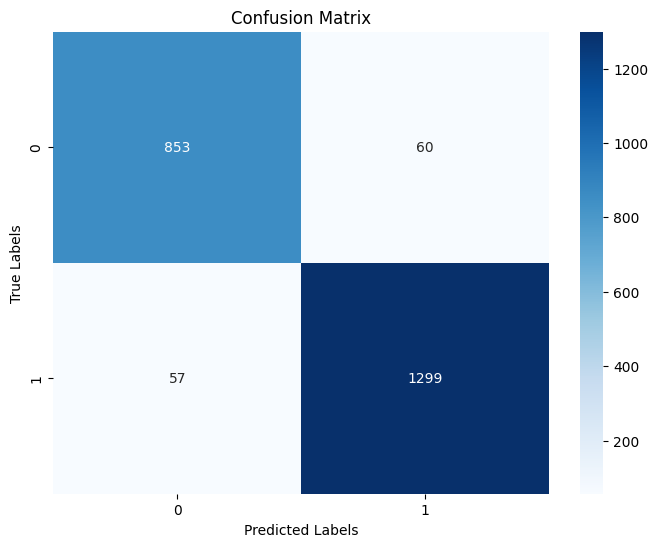

In [15]:
predictions_output = trainer.predict(tokenized_dataset['test'])
y_pred = predictions_output.predictions.argmax(-1)
y_true = predictions_output.label_ids
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

## Save Fine-tuned Model

In [13]:
save_path = "./models/indobert-fp32-combined-finetuned"

trainer.save_model(save_path)
tokenizer.save_pretrained(save_path)

print(f"Model and tokenizer saved to: {save_path}")
print("\nYou can load the model later with:")
print(f"  model = AutoModelForSequenceClassification.from_pretrained('{save_path}')")
print(f"  tokenizer = AutoTokenizer.from_pretrained('{save_path}')")

Model and tokenizer saved to: ./models/indobert-fp32-combined-finetuned

You can load the model later with:
  model = AutoModelForSequenceClassification.from_pretrained('./models/indobert-fp32-combined-finetuned')
  tokenizer = AutoTokenizer.from_pretrained('./models/indobert-fp32-combined-finetuned')
